This notebook is an exploration of how field data can be extracted from the results of a simulation. Since we cannot extract these values using gmsh, we use the simnibs gmsh toolkit - however it comes with caveats as shown below:

In [2]:
import sys

In [3]:
#SCC package environment
sys.path.insert(0,'/KIMEL/tigrlab/projects/jjeyachandra/gmsh-sdk/lib/')
sys.path.insert(0,'/home/jjeyachandra/simnibs_2.1.2/miniconda2/envs/simnibs_env/lib/python2.7/site-packages')
sys.path.insert(0,'/home/jjeyachandra/simnibs_2.1.2/Python_modules/src')

In [53]:
import os
import gmsh
import numpy as np
from timeit import default_timer as timer
from simnibs.msh import gmsh_numpy as simgmsh
import matplotlib.pyplot as plt

In [5]:
#File containing simulation
sim_file = '../../data/simnibs_output/test_simulation/sub-CMH090_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.msh'

In [6]:
#Load mesh
msh = simgmsh.read_msh(sim_file)

#Crop mesh to only include tetrahedral elements
tet_msh = msh.crop_mesh(tags=2)

In [7]:
#Now we want to get just the grey matter elements
norm_E = tet_msh.elmdata[1].value

In [8]:
tet_msh.elm_node_coords()

array([[[-31.833855  ,  24.683672  ,  29.181765  ],
        [-32.49903439,  23.77358006,  30.37456153],
        [-31.745123  ,  24.671728  ,  30.409279  ],
        [-32.312817  ,  25.719074  ,  29.342737  ]],

       [[ 39.68859316,  -4.47707327, -37.25354349],
        [ 38.47295538,  -3.19481116, -39.23273685],
        [ 37.103786  ,  -3.961497  , -38.073193  ],
        [ 38.51841036,  -3.04933624, -37.81565263]],

       [[ 54.864586  , -38.395596  , -10.224445  ],
        [ 52.29897547, -37.16656001, -10.7999081 ],
        [ 54.658424  , -37.151691  , -10.411604  ],
        [ 54.15082568, -37.83382872, -12.77249137]],

       ...,

       [[  1.222491  , -41.907738  ,  27.1861    ],
        [  2.616179  , -42.270012  ,  27.221222  ],
        [  2.268463  , -41.677254  ,  26.813072  ],
        [  2.15951383, -41.20984811,  27.93331375]],

       [[ 53.82251   ,  -5.819618  ,  15.888398  ],
        [ 52.66561605,  -5.24392561,  16.07268392],
        [ 53.936951  ,  -5.672938  ,  17.09

### Question to Answer:
Whether we can find a 1:1 mapping of correspondence between the re-ordered nodes to the original nodes 
Or whether the re-numbering process destroys this correspondence...

In [9]:
#First pull a subset according to what was in tet_elem_param
f_tetra = '../../data/simnibs_output/sub-CMH090.msh'
gmsh.initialize()
gmsh.open(f_tetra)
tet_gm = (3,2)
tet_node_tag, tet_node_coord, tet_node_param = gmsh.model.mesh.getNodes(tet_gm[0],tet_gm[1])
tet_elem_tag, tet_elem_coord, tet_elem_param = gmsh.model.mesh.getElements(tet_gm[0],tet_gm[1])

In [18]:
tet_tags = np.array(tet_elem_coord[0], dtype=np.int64)

In [38]:
#Pull this subset from the original mesh and compare statistics of the field norms
tag_msh = msh.crop_mesh(elements=tet_tags)

In [58]:
tag_normE = tag_msh.elmdata[1].value

We have an exact match, however the issue is still that our node numbering is completely messed around with in a way we can't guarantee that ordering is the same (node maxes are clipped!)

In [51]:
tet_coords = np.array(tet_elem_param[0],dtype=np.int64)
tet_coords = tet_coords.reshape( (tet_coords.shape[0]//4,4) )

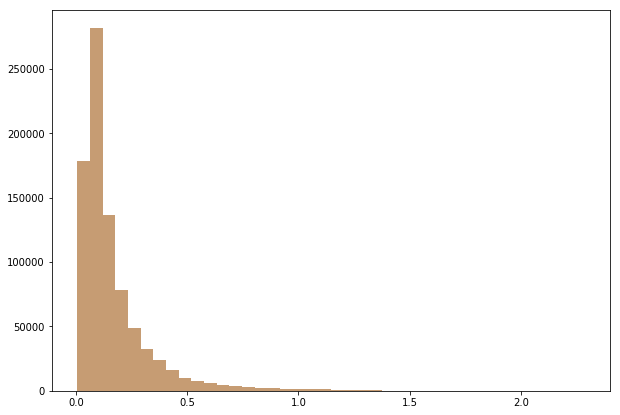

In [63]:
#Plot for comparison
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.hist(tag_normE,bins=40,alpha=0.5)
ax.hist(norm_E,bins=40,alpha=0.5)
plt.show()

Get perfect overlap indicating that we did extract the correct nodes. The next question is how we can guarantee that the ordering of the nodes aren't messed up...

We can try manually extracting from the entire mesh and comparing the ordering using node tags

In [71]:
#From elmdata pull the relevant tags
elm_subset = msh.elmdata[1].value[tet_tags]

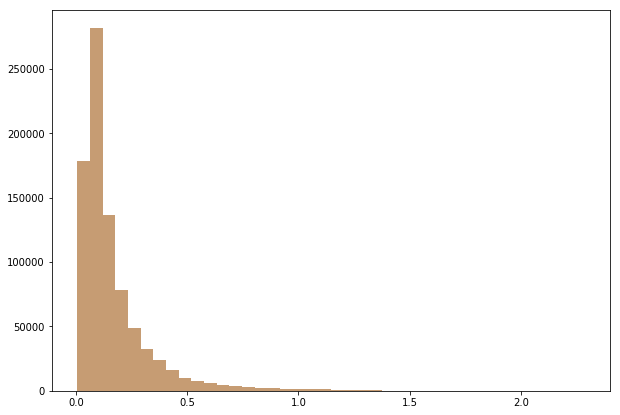

In [78]:
#Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.hist(norm_E,bins=40,alpha=0.5)
ax.hist(elm_subset,bins=40,alpha=0.5)
plt.show()

Now we have evidence that the values are equivalent when pulling from the full mesh, checking that the arrays themselves are ordered in the same way (i think not..)

In [80]:
np.array_equiv(elm_subset,norm_E)

False

This indicates the cropping a full mesh not only re-numbers the element tag data, but it also changes the order of the representation. We can avoid this by passing on the element data from the original mesh and subsetting the field data directly rather than cropping (as they do in simnibs examples)